In [19]:
import numpy as np
import cv2
import argparse
import imutils
import matplotlib.pyplot as plt
from imutils import contours
from imutils.perspective import four_point_transform

In [9]:
## Parsear os argumentos para uso no terminal
#ap = argparse.ArgumentParser()
#ap.add_argument("-i", "--image", required=True,
#               help = "path to the input image")
#args = vars(ap.parse_args())

## Mocando para jupyter
args = dict()
args['image'] = 'omr_test_01.png'

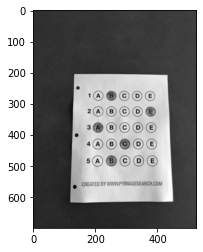

In [21]:
# abrir image e filtrar ela

imagem = cv2.imread('omr_test_01.png')
# Verificar se imagem é valida

cinza_img = cv2.cvtColor(imagem, cv2.COLOR_BGR2GRAY)

blur_img = cv2.GaussianBlur(cinza_img, (5, 5), 0)
detec_contorno_canny = cv2.Canny(blur_img, 75, 200)

plt.imshow(blur_img, cmap='gray')

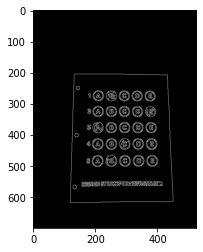

In [22]:
plt.imshow(detec_contorno_canny, cmap='gray')

In [62]:
# É importante que todos vertices estejam na imagem para marcar transformação

# Achar contorno

contornos = cv2.findContours(detec_contorno_canny.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

contornos = imutils.grab_contours(contornos)

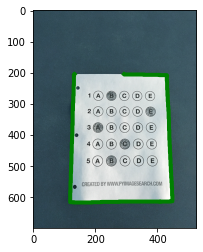

In [73]:
# Mostrando esse contorno
list_x = []
list_y = []
for i in contornos[0]:
    list_x.append(i[0][0])
    list_y.append(i[0][1])

img_copia = imagem.copy()

plt.plot(list_x, list_y, 'g', linewidth=4)
plt.imshow(img_copia)

In [88]:
# verificar se achou contorno

pontos_contorno = None

# Achou um contorno
if len(contornos) > 0:
    # Organizar contornos de acordo com seu tamanho
    contornos = sorted(contornos, key=cv2.contourArea, reverse=True)
    # Se encontrarmos mais de um contorno escolheremos o de maior area
    
    # Tentar cada contorno até conseguir 4 pontos
    for contorno in contornos:
        perimetro = cv2.arcLength(contorno, True)
        print('Perimetro:', perimetro)
        pontos = cv2.approxPolyDP(contorno, 0.02 * perimetro, True)
        
        if len(pontos) == 4:
            pontos_contorno = pontos
            break
            
print('Pontos aproximados: \n',pontos)

Perimetro: 1462.811182141304
Pontos aproximados: 
 [[[131 206]]

 [[119 617]]

 [[448 614]]

 [[430 208]]]


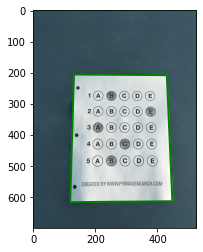

In [92]:
lista_x = []
lista_y = []

for ponto in pontos_contorno:
    lista_x.append(ponto[0][0])
    lista_y.append(ponto[0][1])
lista_x.append(pontos_contorno[0][0][0])
lista_y.append(pontos_contorno[0][0][1])

plt.plot(lista_x, lista_y, 'g', linewidth=2)
plt.imshow(img_copia)

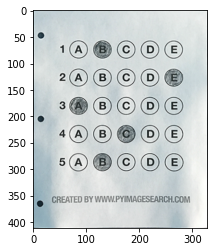

In [171]:
# Transformação de perspectiva

# Vamos aplicar na imagem original e na vista superior do papel

original = four_point_transform(imagem, pontos.reshape(4,2))
plt.imshow(original)

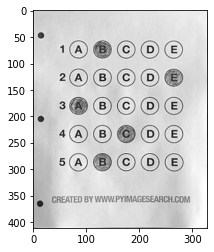

In [163]:
cinza = four_point_transform(cinza_img, pontos.reshape(4,2))
plt.imshow(cinza, cmap='gray')

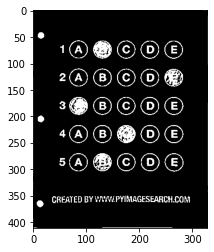

In [164]:
# Threshold para binarização da imagem

thresh_img = cv2.threshold(cinza, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
plt.imshow(thresh_img, cmap='gray')

In [165]:
# Achar contornos na imagem

contornos = cv2.findContours(thresh_img.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
contornos = imutils.grab_contours(contornos)

print(len(contornos))

# OpenCV

82


In [166]:
contornos_perguntas = []

for contorno in contornos:
    # Obter caixa do contorno, ai usar aspect-radio para verificar
    
    (x,y, w, h) = cv2.boundingRect(contorno)

    razao = w / float(h)
    
    # Condições que definem um circulo
    
    raio_min = 20
    tolerancia = 0.1
    
    if w >= raio_min and h >= raio_min and razao >= 1-tolerancia and razao <= 1 + tolerancia:
        contornos_perguntas.append(contorno)
print('Circulos de resposta: ',len(contornos_perguntas))

Circulos de resposta:  25


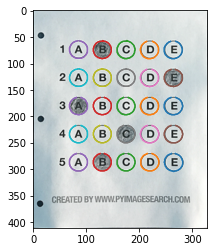

In [167]:
for contorno in contornos_perguntas:
    lista_x = []
    lista_y = []
    for ponto in contorno:
        lista_x.append(ponto[0][0])
        lista_y.append(ponto[0][1])
    plt.plot(lista_x, lista_y)
plt.imshow(original)

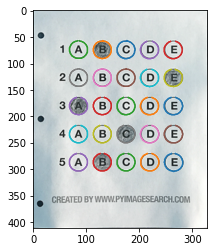

In [189]:
# Agora temos então todas as bolhas de questões

# Vamos organizar essa lista de questões de cima para baixo

contornos_perguntas_ord = contours.sort_contours(contornos_perguntas, method='top-to-bottom')[0]
for contorno in contornos_perguntas_ord:
    lista_x = []
    lista_y = []
    for ponto in contorno:
        try:
            lista_x.append(ponto[0][0])
            lista_y.append(ponto[0][1])
        except:
            pass
    plt.plot(lista_x, lista_y)
plt.imshow(original)

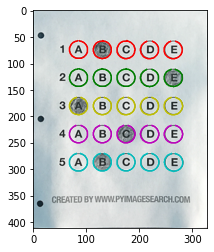

In [267]:
# Cada questão tem 5 possiveis respostas, ESTAMOS ASSUMINDO ISSO, nao sei se precisa organizar em questao, TALVEZ obtenha fazer loop e vendo quando tiver uma mudanca brusca no y quando tiver analisando as contornos_perguntas_ord

index= 0
cores = ['r','g','y','m', 'c']
questoes_ordenadas = []

for (questao,indice) in enumerate(np.arange(0, len(contornos_perguntas_ord), 5)):
    # ordena os contornos da esquerda pra direita
    
    contornos = contours.sort_contours(contornos_perguntas_ord[indice:indice+5])[0]
    questoes_ordenadas.append(contornos)
    for contorno in contornos:
        lista_x = []
        lista_y = []
        for ponto in contorno:
            lista_x.append(ponto[0][0])
            lista_y.append(ponto[0][1])
        plt.plot(lista_x, lista_y, cores[index // 5])
        index+=1
plt.imshow(original)

In [262]:
# Verificar quais respostas foram escolhidas

respostas = []

for (indice, opcoes) in enumerate(questoes_ordenadas):
    total = 0
    
    # A ideia de guardar peso é que no futuro pode-se decidir se a pessoa marcou mais de uma
    pesos = []
    respostas.append(dict())
    
    for (index, opcao) in enumerate(opcoes):
        mask = np.zeros(thresh_img.shape, dtype="uint8")
        cv2.drawContours(mask, [opcao], -1, 255, -1)
        
        # Vamos contabilizar quantos pixels não nulas na area da bolha
        mask = cv2.bitwise_and(thresh_img, thresh_img, mask=mask)

        # Dentro de cada contorno temos um numero de "escuros"
        escuros = cv2.countNonZero(mask)
        pesos.append(escuros)
        
        if escuros > total:
            total = escuros
            respostas[indice]['resposta'] = index
    
    respostas[indice]['pesos'] = pesos

print(respostas)

[{'resposta': 1, 'pesos': [289, 817, 290, 320, 300]}, {'resposta': 4, 'pesos': [279, 328, 290, 307, 686]}, {'resposta': 0, 'pesos': [794, 318, 285, 326, 316]}, {'resposta': 2, 'pesos': [294, 323, 805, 331, 320]}, {'resposta': 1, 'pesos': [286, 722, 294, 324, 317]}]


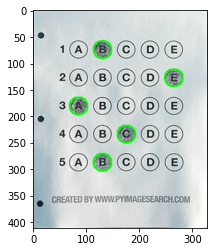

In [272]:
copia_img = original.copy()

for (indice, opcoes) in enumerate(questoes_ordenadas):
    resposta = respostas[indice]['resposta']
    opcao_escolhida = questoes_ordenadas[indice][resposta]
    
    cv2.polylines(copia_img, [opcao_escolhida], True, (0,255,0), 2)

plt.imshow(copia_img)

In [266]:
# FUNCOES QUE MARCAM COM CIRCULO: ACEITAM A QUESTAO, A OPCAO E A COR COMO VARIAVEL

# FUNCAO QUE RETORNA AS RESPOSTAS COMO DICT

# MARCAR DE ACORDO COM O PESO, ACIMA DE UM CERTO PESO A RESPOSTA PODE SER ANULADA, ABAIXO TAMBEM

# Inves de analisar a resposta, pode deletar essa opçao, retorna os pesos, e acima de um certo peso, sabe que é a resposta